### Example 6: Poisson equation

In the previous example we have seen how to solve the steady-state Laplace equation with a prescribed boundary condition and BCs that contain derivatives (Neumann BC). For this we used a pseudo-timestepping to illustrate the use of two explicit data symbols of type `Function` to derive at a steady state. In this example we are going to solve the Poisson equation (step 10 of the original tutorial series) with an initial condition to demonstrate how we can combine time-dependent functions of type `TimeFunction` with time-constant `Function` symbols. We will again implement a Python-driven outer loop for the diffusion kernel, before demonstrating how we can change the expression defining our operator to internalize the pseudo-timestepping and thus get the full performance advantage of compiled kernel loops.

Our governing equation is the Poisson equation with a souce term as the RHS:
$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

Discretizing and rearranging our stencil expression yields
$$p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2-b_{i,j}^{n}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

The key difference to the Laplace example in the previous tutorial is that this example has simple Dirichlet boundary conditions $p = 0$ on all boundaries and is instead driven by the source term $b$ defined as

$b_{i,j}=100$ at $i=nx/4, j=ny/4$

$b_{i,j}=-100$ at $i=nx*3/4, j=3/4 ny$

$b_{i,j}=0$ everywhere else.

And of course, we will demonstrate the original example first using pure NumPy notation.

In [1]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 50
ny = 50
nt  = 100
xmin = 0.
xmax = 2.
ymin = 0.
ymax = 1.

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

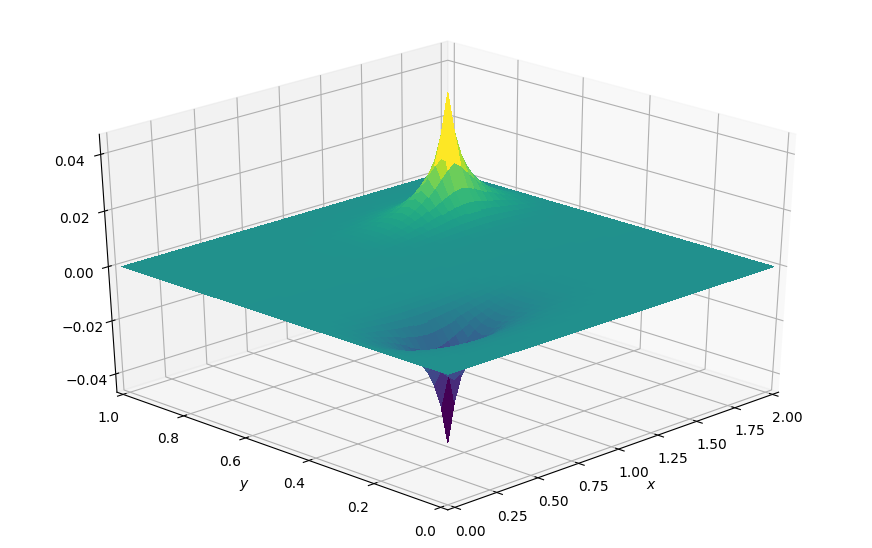

In [2]:
#NBVAL_IGNORE_OUTPUT

# Initialization
p  = np.zeros((nx, ny))
pd = np.zeros((nx, ny))
b  = np.zeros((nx, ny))

# Source
b[int(nx / 4), int(ny / 4)]  = 100
b[int(3 * nx / 4), int(3 * ny / 4)] = -100

for it in range(nt):
    pd = p.copy()
    p[1:-1,1:-1] = (((pd[1:-1, 2:] + pd[1:-1, :-2]) * dy**2 +
                    (pd[2:, 1:-1] + pd[:-2, 1:-1]) * dx**2 -
                    b[1:-1, 1:-1] * dx**2 * dy**2) / 
                    (2 * (dx**2 + dy**2)))

    p[0, :] = 0
    p[nx-1, :] = 0
    p[:, 0] = 0
    p[:, ny-1] = 0
    
plot_field(p, xmax=xmax, ymax=ymax, view=(30, 225))

We can now pretty much use our previous implementation, although we will use `pd` instead of `pn` for consistency with the original. Our boundary conditions are even simpler since they are $0$ everywhere. Our source term is neatly wrapped in the symbol `b` and we can again use a Python-driven timestepping loop with switching buffers to repeatedly execute the operator we create.

In [3]:
from devito import Grid, Function, TimeFunction, Operator, configuration, Eq, solve

# Silence the runtime performance logging
configuration['log-level'] = 'ERROR'

# Now with Devito we will turn `p` into `TimeFunction` object 
# to make all the buffer switching implicit
grid = Grid(shape=(nx, ny), extent=(1., 2.))
p = Function(name='p', grid=grid, space_order=2)
pd = Function(name='pd', grid=grid, space_order=2)
p.data[:] = 0.
pd.data[:] = 0.

In [4]:
# Initialise the source term `b`
b = Function(name='b', grid=grid)
b.data[:] = 0.
b.data[int(nx / 4), int(ny / 4)]  = 100
b.data[int(3 * nx / 4), int(3 * ny / 4)] = -100

In [5]:
# Create Laplace equation base on `pd`
eq = Eq(pd.laplace, b, subdomain=grid.interior)
# Let SymPy solve for the central stencil point
stencil = solve(eq, pd)
# # Now we let our stencil populate our second buffer `p`
eq_stencil = Eq(p, stencil)

In [6]:
# Create boundary condition expressions
x, y = grid.dimensions
t = grid.stepping_dim
bc = [Eq(p[x, 0], 0.)]
bc += [Eq(p[x, ny-1], 0.)]
bc += [Eq(p[0, y], 0.)]
bc += [Eq(p[nx-1, y], 0.)]

In [7]:
# Now we can build the operator that we need
op = Operator([eq_stencil] + bc)

In [8]:
# Run the outer loop explicitly in Python
for i in range(nt):
    # Determine buffer order
    if i % 2 == 0:
        _p = p
        _pd = pd
    else:
        _p = pd
        _pd = p

    # Apply operator
    op(p=_p, pd=_pd)

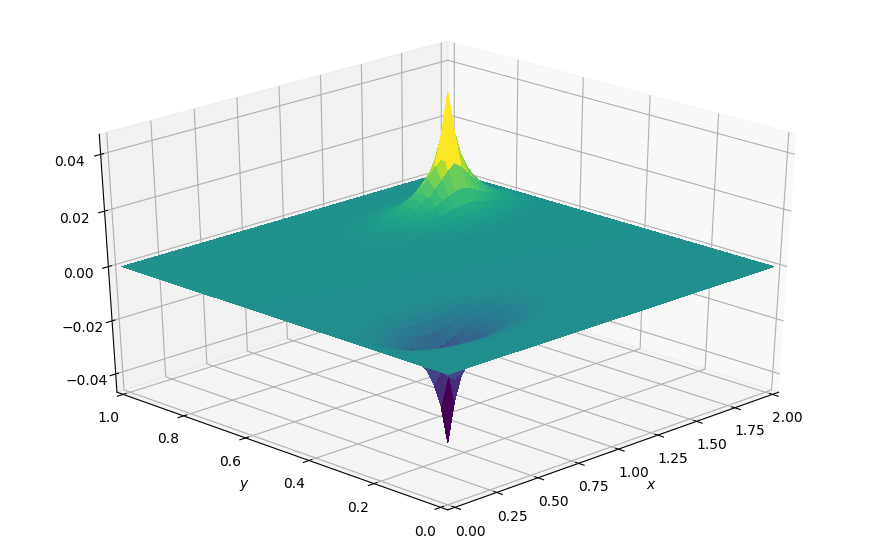

In [9]:
#NBVAL_IGNORE_OUTPUT
# Plot result
plot_field(p.data, xmax=xmax, ymax=ymax, view=(30, 225))

Nice, we get the same spikes as the pure NumPy implementation. But we still drive the time loop though Python, which is slow. So let's try and utilise Devito's time-stepping mechanism that we saw earlier for this "pseudo-timestepping". 

The trick here is to again use `TimeFunction` symbols, despite the lack of a time-dependence. This will cause Devito to allocate two grid buffers instead of one, which we can directly address them via the terms `p` and `p.forward`. This will now create an internal time loop in the kernel that we can again control by supplying the `time` argument to the create operator during invocation.

One caveat, however, is that a `TimeFunction` symbol has an implicit time dimension `t`, so the symbol is denoted as `p(t, x, y)`. This entails that, when creating our boundary condition expressions, we now need honour the leading time dimension in the "low-level" notation, and ensure that we update the index `t + 1` (the equivalent to `u.forward`).

In [10]:
#NBVAL_IGNORE_OUTPUT

# Now with Devito we will turn `p` into `TimeFunction` object 
# to make all the buffer switching implicit
p = TimeFunction(name='p', grid=grid, space_order=2)
p.data[:] = 0.
          

In [11]:
# Initialise the source term `b`
b = Function(name='b', grid=grid)
b.data[:] = 0.
b.data[int(nx / 4), int(ny / 4)]  = 100
b.data[int(3 * nx / 4), int(3 * ny / 4)] = -100

In [12]:
# Create Laplace equation base on `p`
eq = Eq(p.laplace, b)
# Let SymPy solve for the central stencil point
stencil = solve(eq, p)
# Let our stencil populate the buffer `p.forward`
eq_stencil = Eq(p.forward, stencil)

In [13]:
# Create boundary condition expressions
# Note that we now add an explicit "t + 1" for the time dimension.
bc = [Eq(p[t + 1, x, 0], 0.)]
bc += [Eq(p[t + 1, x, ny-1], 0.)]
bc += [Eq(p[t + 1, 0, y], 0.)]
bc += [Eq(p[t + 1, nx-1, y], 0.)]

In [14]:
#NBVAL_IGNORE_OUTPUT
# We can even switch performance logging back on,
# since we only require a single kernel invocation.
configuration['log-level'] = 'INFO'

# Create and execute the operator for a number of timesteps
op = Operator([eq_stencil] + bc)
op(time=nt)

Operator `Kernel` run in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0004519999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0001109999999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

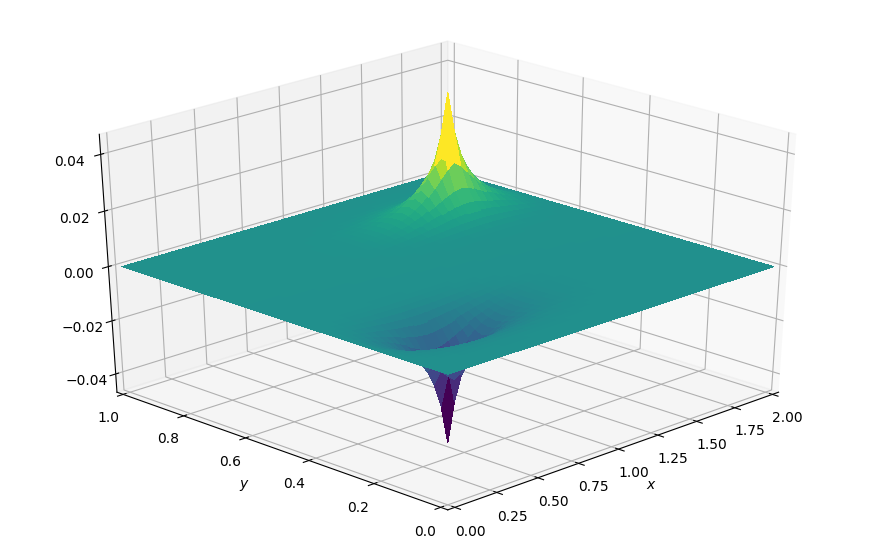

In [15]:
#NBVAL_IGNORE_OUTPUT
plot_field(p.data[0], xmax=xmax, ymax=ymax, view=(30, 225))